# T017 · Advanced NGLview usage

Authors:

- Jaime Rodríguez-Guerra, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

[NGLView](http://nglviewer.org/nglview/latest/) is a powerful Jupyter widget that allows you to show molecular structures in your notebooks in a 3D interactive view! It supports both single conformations and trajectories, as well as a plethora of representations. In this talktorial we will cover how to use it in different scenarios, from simpler cases to more intricate ones.

### Contents in *Theory*

* NGL and NGLView
* NGL object model and terminology

### Contents in *Practical*

* First steps: make sure everything works!
    * Experiment with the interactive controls
* Basic API usage:
    * Show a structure using its PDB identifier
    * Show a structure using a local file
    * Saving the widget state as a screenshot for offline viewing
    * Customize the representations
    * Control representations by selections
    * NMR and multimodel structures
    * Load more than one structure
    * Show and hide components
* Advanced usage:
    * Custom coloring schemes and representations
    * Add geometric objects at selected atoms
    * Create interactive interfaces
    * Access the JavaScript layer
* Troubleshooting tips:
    * Check which Jupyter platform you are working from
    * How to install `nglview`, the right way

### References

* **NGL manuscript**: Rose *et al.*, <i>Nucl Acids Res.</i> (2015), <b>43</b> (W1), W576-W579 (https://academic.oup.com/nar/article/43/W1/W576/2467902)
* [NGL documentation](http://nglviewer.org/ngl/api/) and [repository](https://github.com/nglviewer/ngl)
* **NGLView manuscript**: Nguyen *et al.*, <i>Bioinformatics</i> (2018), <b>34</b> (7), 1241-1242 (https://academic.oup.com/bioinformatics/article/34/7/1241/4721781)
* [NGLView documentation](http://nglviewer.org/nglview/latest/) and [repository](https://github.com/nglviewer/nglview)
* [NGLView Q&A issues](https://github.com/nglviewer/nglview/issues?q=is%3Aissue+label%3AQ%26A). A lot of hidden knowledge in these conversations!
* [NGLView examples](https://github.com/nglviewer/nglview/tree/master/examples)
* [Jupyter Widgets (IPyWidgets)](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html)

## Theory

### NGL and NGLView

NGL is a [WebGL](https://www.khronos.org/webgl/)-accelerated JavaScript library for the depiction of 3D macromolecular structures on your browser. It doesn't require any software installation! It has been widely adopted in the data science community, partially thanks to the NGLView integrations in the Jupyter ecosystem. While tightly connected, NGL and NGLView are two separate projects and understanding this difference is key.

* NGL is the JavaScript library that renders the molecular structures in your browser using WebGL. It can be embedded in any webpage, see the [demo application](http://nglviewer.org/ngl/?script=component/structure-biomol).
* NGLView _wraps_ NGL so it can be used from a Jupyter notebook running a Python kernel. This is possible thanks to the integrations provided by the [IPyWidgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html) project.

When you `import nglview`, you are loading a Python package that knows how to talk to the underlying JavaScript library. The process of telling `nglview` which structure you want to see involves more steps than you may think!

* Importing the package:
    * `import nglview` _only_ loads `nglview` Python package. This is usually provided by `conda` or `pip`. 
    * The Python package must now find the JavaScript components. These are bundled as part of the Python package data files, but they need to be placed in the right location so the browser can load them in the Jupyter UI. 
    * Importing the Python package successfully does not necessarily imply that the JavaScript layer was loaded correctly! _Note_: This is a common error and we have covered some troubleshooting at the end of the talktorial.
* Showing a 3D structure:
    *  When you ask for a PDB ID to be shown, NGLView will pass NGL the URL of the file you want to download. Then, the JavaScript layer takes over and downloads the contents to your browser's memory, creates JavaScript objects for the macromolecular structure and then renders it in a WebGL-enabled `<canvas>` HTML5 element.
    * If you want to open a local file, you can either:
        * Open the file with Python and pass the _contents_ of the file to NGL.
        * Pass the location of the file in disk to NGLView, which will transform it to a _download_ link that NGL (being JavaScript) can use to get access to the file. _Note_: This step is fragile and can break with different package versions, so we recommend opening the file in Python first. An example is provided later!
    * If you want to view a molecular object as provided by a Python library (RDKit, BioPython, MDAnalysis...), NGLView will try to recognize the object model and convert it to a suitable format for NGL (usually a PDB string). This happens transparently through some helper functions.

Given the complexity of these interactions, you must understand that NGLView only provides a Python interface to the most common features provided by NGL. Some of its advanced features are not exposed directly, but the good news is that you can always _send_ code snippets to the underlying JavaScript objects.

We will cover all of these subtleties with different examples through this talktorial.

### NGL object model and terminology

When you ask for a 3D viewer, NGLView (the Python package) will create an object called `NGLWidget`, which wraps the NGL `Stage` JavaScript object in an IPyWidget object. `NGLWidget` acts as the bridge between Python and JavaScript. When you autocomplete on a `view` instance, you are exploring the `NGLWidget` _Python_ attributes and methods.

Once you are in JavaScript territory, you are handling the NGL object model. This basically consists of the `Stage`, which can host one or more _components_. A _component_ can be a molecular structure or a geometric shape. Components can be rendered with one or more _representations_. For example, when you see a protein ligand complex (like, let's say, PDB ID [3PK2](https://www.rcsb.org/structure/3pk2)), you are seeing:

* The NGL `Stage`, the interactive canvas
* A single component, the in-memory JavaScript object for 3PK2. Take into account that a _component_ can store more than one _molecule_ or _model_ in the physical sense!
* Two representations: ribbon for the backbone, ball and stick for the ligand
* If you want to see the water molecules too, you would add one more representation targeting only the solvent.

Representations do not only include how the structure looks like. The NGL implementation also considers some types of measurements as _representations_. If you want to see the van der Waals surface, that's a representation in NGL terms. Measuring the distance between two atoms and displaying that as a pointed line, that's a representation too. Same goes for labels.

However, if you want to add a shape that points to an arbitrary spot in your protein, that's a shape, which is a subtype of a component! 

Confusing? One way to remember the difference: representations _depend_ on the coordinates provided by a component. They don't have coordinates or their own! Shapes, being able to be placed in arbitrary places, are not representations, but components on their own.

To make sure you got the gist, you can also check the [examples in the demo application](http://nglviewer.org/ngl) (dropdown in the top menu) and get more familiar with the NGL terminology. Each example will load a state on the 3D canvas, with components being on the top level of the hierarchy, and their representations under each one.

This should cover the core concepts at the theory level, but this won't make much sense until you see it in action so... let's go!

## Practical

> Note: Since NGLView is an interactive widget, most of the features discussed in this talktorial will be best enjoyed in a running Jupyter environment. If you are reading this from the online static preview, you are missing out a lot of cool things!

In [1]:
from pathlib import Path

HERE = Path(_dh[-1])
DATA = HERE / "data"

### First steps: make sure everything works!

In [2]:
import nglview as nv

nv.demo()

NGLWidget()

If you don't see a 3D interactive view of protein in the output of the cell above, check the **Troubleshooting tips** section at the end of this notebook.

#### Experiment with the interactive controls

The view above is interactive! You can use your mouse to:

* **Translation**: right click + drag
* **Rotation**: left click + drag
* **Z-axis rotation**: <kbd>Ctrl</kbd> + right click + drag
* **Zoom**: scroll wheel
* **Center view**: left click on the desired atom (or its representation)

You can also represent distances, angles and dihedrals by following this procedure:

1. Right click on a single atom. You'll see a green sphere wrapping it.
2. Right click on another atom. You'll see now two green spheres. You can add up to four atoms to a selection this way (including the first one)
3. Right click again on the last atom you selected to finalize the operation. 
    * If you picked two atoms, you'll see a dashed line between the two atoms, along with the reported **distance** in Å.
    * If you picked three atoms, you'll see a circular sector with the **angle** reported in degrees (°).
    * If you picked four atoms, you'll see a circular sector with the **dihedral angle** reported in degrees (°).

To remove a distance/angle/dihedral representation, repeat the sequence on the same atoms.

![Geometric measurements on NGLView](images/nglview_picking.gif)

Figure: Step by step procedure to represent geometric measurements in NGLView.

### Basic API usage

`nglview` wraps the `ngl.js` JavaScript library with an `IPyWidget` subclass named `NGLWidget`. You can create widget objects using the class directly:

```python
viewer = nv.NGLWidget()
```

But for simple cases, it's more convenient to use the `nv.show_*` helper functions. This is the current list of functions available:

In [3]:
print("NGLView version:", nv.__version__)
for attr in dir(nv):
    if attr.startswith("show_"):
        print(f"  nv.{attr}(...)")

NGLView version: 2.7.7
  nv.show_ase(...)
  nv.show_asetraj(...)
  nv.show_biopython(...)
  nv.show_file(...)
  nv.show_htmd(...)
  nv.show_iodata(...)
  nv.show_iotbx(...)
  nv.show_mdanalysis(...)
  nv.show_mdtraj(...)
  nv.show_openbabel(...)
  nv.show_parmed(...)
  nv.show_pdbid(...)
  nv.show_prody(...)
  nv.show_psi4(...)
  nv.show_pymatgen(...)
  nv.show_pytraj(...)
  nv.show_qcelemental(...)
  nv.show_rdkit(...)
  nv.show_rosetta(...)
  nv.show_schrodinger(...)
  nv.show_simpletraj(...)
  nv.show_structure_file(...)
  nv.show_text(...)
  nv.show_url(...)


Note how it has functions for:

* local files (different file formats are supported out of the box, check the list [here](https://nglviewer.org/ngl/api/manual/file-formats.html))
* online resources (PDB IDs, URLs...)
* objects from popular libraries (BioPython, MDAnalysis, RDKit...). This includes both single structures _and_ trajectories! You can see it in action in Talktorial T020.

#### Show a structure using its PDB identifier

Use `nv.show_pdbid`:

In [4]:
nv.show_pdbid("3pk2")

NGLWidget()

#### Show a structure using a local file

In other cases, you will have a local file produced by other parts of your pipeline, or downloaded from a non-RCSB resource. To load local files, you would need to use `nv.show_file("path/to/local/file.pdb")`. If you are using Jupyter Notebook as the UI, this will work out of the box.

However, the Jupyter ecosystem is moving towards Lab, where things work a bit differently. One of them is accessing local files. This is a [known issue](https://github.com/nglviewer/nglview/issues/929), so we are going to provide a workaround until this is fixed. The trick consists of opening the file with Python first, and then passing the handler to NGLView, instead of the path. You also need to specify the extension for that file handler (`pdb` in this example). `display(...)` is needed to explicitly export the widget view to the output because we are inside the `open()` context manager.

In [5]:
with open(DATA / "1ARM.pdb") as f:
    display(nv.show_file(f, ext="pdb"))

NGLWidget()

You can also save the widget returned by the function (`view`, by convention) and evaluate it at the global level:

In [6]:
with open(DATA / "1ARM.pdb") as f:
    view = nv.show_file(f, ext="pdb")
view

NGLWidget()

This has the advantage of allowing you to modify the state of the widget from the Python interface, as you will see in the next steps.

#### Saving the widget state as a screenshot for offline viewing

In some cases, you might want to take a screenshot of the current state of the widget (e.g. to save a static preview). This is a step that _necessarily_ involves three separate cells. Although it is very tempting to merge all the cells together, it will _not_ work unless each cell is run separately:

* `view` will show the widget output. You can use your mouse to move it to a nice orientation, if you want.
* `view.render_image(...)` will export the current canvas contents from the JavaScript layer to the Python layer. This is the "screenshot" moment.
* `view._display_image()` will export the contents of the Python layer to the cell output.

In [7]:
view

NGLWidget(n_components=1)

In [8]:
view.render_image(trim=True, factor=2)
# trim=True will remove the empty padding in the canvas

Image(value=b'', width='99%')

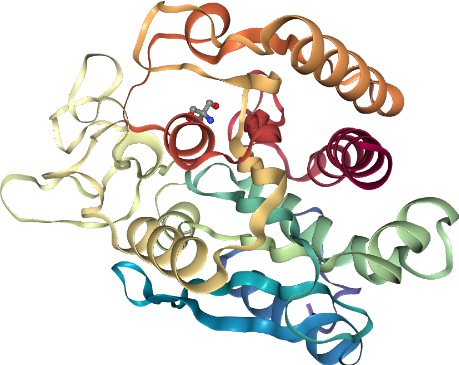

In [9]:
view._display_image()

#### Customize the representations

You can add more representations using the `view.add_*` methods. The following ones are available. Take into account that in NGL, a representation can include visual tools other than how a protein or ligand is depicted. For example, calculating (and showing) distance measurements is also a _representation_. We will talk more about this later, but you can also check this part of the [NGL documentation](http://nglviewer.org/ngl/api/manual/molecular-representations.html).

> Note that some `.add_*` functionalities actually are convenience methods to _add_ more _components_ to the canvas, not representations! This is the case with `add_component`, `add_pdbid`, `add_structure` and `add_trajectory`, among others.

In [10]:
for attr in dir(view):
    if attr.startswith("add_"):
        print(f"view.{attr}(...)")

view.add_axes(...)
view.add_backbone(...)
view.add_ball_and_stick(...)
view.add_cartoon(...)
view.add_class(...)
view.add_component(...)
view.add_contact(...)
view.add_distance(...)
view.add_helixorient(...)
view.add_hyperball(...)
view.add_label(...)
view.add_licorice(...)
view.add_line(...)
view.add_pdbid(...)
view.add_point(...)
view.add_principal_axes(...)
view.add_representation(...)
view.add_ribbon(...)
view.add_rocket(...)
view.add_rope(...)
view.add_simplified_base(...)
view.add_slice(...)
view.add_spacefill(...)
view.add_structure(...)
view.add_surface(...)
view.add_trace(...)
view.add_traits(...)
view.add_trajectory(...)
view.add_tube(...)
view.add_unitcell(...)


Note that each representation type admits arbitrary keyword arguments that are not documented in the Python layer. Refer to the JavaScript documentation to see how you can customize each one. See the `*RepresentationParameters` objects [here](http://nglviewer.org/ngl/api/typedef/index.html).

> Tip: Use <kbd>Ctrl</kbd>+<kbd>F</kbd> to find for the correct entry in the table of contents on the left!

Another way to find the options is to look at the `*Representation` constructor method. For example, if you want to add a _ball and stick_ representation, you will need the `add_ball_and_stick` method. Search for `ballandstick` and you will arrive to the JavaScript class `BallAndStickRepresentation` [here](http://nglviewer.org/ngl/api/class/src/representation/ballandstick-representation.js~BallAndStickRepresentation.html). You will see the `params` attribute in the constructor docstring, which will take you to the table of options you can use (see [here](http://nglviewer.org/ngl/api/typedef/index.html#static-typedef-BallAndStickRepresentationParameters)):

* `sphereDetail`
* `radialSegments`
* `openEnded`
* `disableImpostor`
* `aspectRatio`
* `lineOnly`
* `linewidth`
* `cylinderOnly`
* `multipleBond`
* `bondSpacing`
* `bondScale`

> Unfortunately, some representations are not fully documented, so you might even need to dive in to the JavaScript source... at that point, you might want to ask for help in their GitHub repository!

#### Control representations by selections

If you combine all those `add_*` functions with [NGL's powerful selection language](http://nglviewer.org/ngl/api/manual/selection-language.html) you can adapt the style of your structures to your liking. This is specially useful when you disable the default representation to start from scratch.

For this example, we will use [3PK2](https://www.rcsb.org/structure/3pk2), a streptavidin binded to a biotine derivative that is coordinated to a transition metal ion (Iridium). For details see [4IR](https://www.rcsb.org/ligand/4IR). This is considered an _artificial metalloenzyme_, how cool is that?! 

In [11]:
view = nv.show_pdbid("3pk2", default_representation=False)
view

NGLWidget()

The above widget is now completely _blank_. That doesn't mean the structures were not loaded (the _components_ are loaded but no _representation_ is set, yet). Then, we have to add representations. Look how the widget updates over the next steps:

In [12]:
# add ribbon to protein only
view.add_cartoon("protein")
view

NGLWidget()

Now we want to ask the JS backend to render the current state of the widget to an internal image buffer with `.render_image`. We will use this to depict the progressive changes to the representation over the next cells.

Details:

* `trim=True` removes the blank padding around the molecule
* `factor=2` asks for a 2x resolution render for higher quality, but not too much (default is 4x)

In [13]:
view.render_image(trim=True, factor=2);

Once rendered, we can show the screenshot in the notebook!

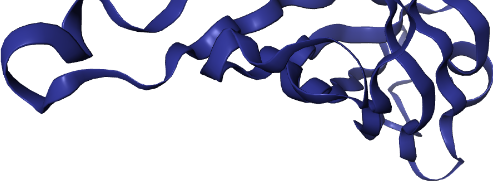

In [14]:
view._display_image()

By default, the camera is not centered on the molecule, but we can remediate that with `.center()`

In [15]:
view.center()
view.render_image(trim=True, factor=2);

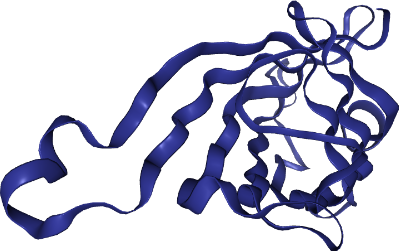

In [16]:
view._display_image()

Didn't we say we had a super cool ligand? Where is it? Hm, let's add a ball & stick representation for it!

In [17]:
view.add_ball_and_stick("ligand")
view.render_image(trim=True, factor=2);

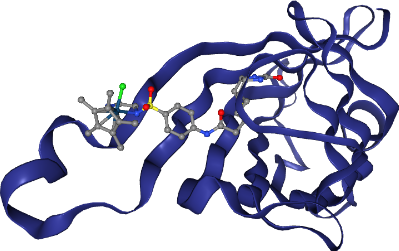

In [18]:
view._display_image()

Crystallographic waters should be displayed, but in a subtle way that does not get in the way. `line` representations work nice for this.

In [19]:
view.add_line("water")
view.render_image(trim=True, factor=2);

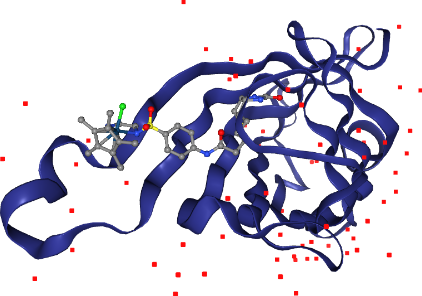

In [20]:
view._display_image()

Oh, we almost forgot about the Iridium ion. Where is it? We better highlight it so we don't miss it.  We can ask for a larger sphere style if we use `spacefill` for that atom only. We can select by elements using `_` in front of the element _symbol_.

In [21]:
view.add_spacefill("_Ir")
view.render_image(trim=True, factor=2);

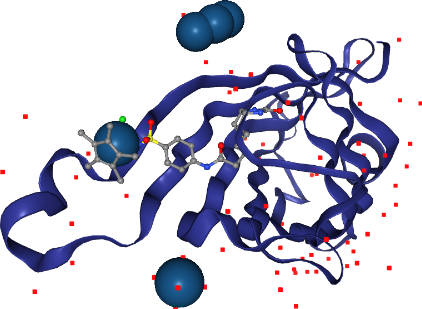

In [22]:
view._display_image()

Wait, in addition to the ligand Iridium, we can see more in other parts of the solvent? Hm, we don't want to see those, since they are probably artifacts of the X-ray preparation. Let's undo the last step with the corresponding `.remove_*()` method.

In [23]:
view.remove_spacefill()
view.render_image(trim=True, factor=2);

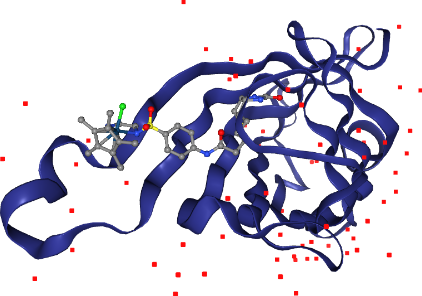

In [24]:
view._display_image()

Now, let's add `spacefill` again, but only for the Iridium ion in the ligand. The selection query needs to satisfy atoms that are both Iridium _and_ part of the ligand. 

In [25]:
view.add_spacefill("ligand and _Ir")
view.render_image(trim=True, factor=2);

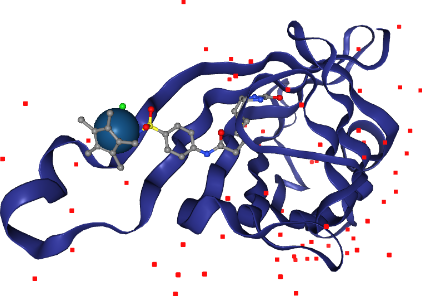

In [26]:
view._display_image()

Perfect!

#### NMR and multimodel structures 
If you are dealing with NMR structures or multimodel PDBs, there will be multiple conformations. By default, only the first one will be loaded:

In [29]:
# By default, first model only
nv.show_pdbid("1rfo")

NGLWidget()

To display all of them, you need to disable the default representation and provide your own:

In [30]:
# all models require custom representation
view = nv.show_pdbid("1rfo", default_representation=False)
view.center()
view.add_cartoon()
view

NGLWidget()

#### Load more than one structure

Once you have the `view` instance around, you can start doing more advanced stuff with NGLView! For example, loading more than one structure! 

Let's start with some depictions of _Bos taurus_' carboxypeptidase. The RCSB contains several structures for this enzyme. We can choose two of them that are very similar, except for a little difference. That way, if we load both on NGLView and show/hide one at a time, we will be able to spot the differences right away!

* [1YME](https://www.rcsb.org/structure/1yme): Structure of carboxypeptidase, which features a Zn ion
* [1ARM](https://www.rcsb.org/structure/1arm): Same structure, but the Zn has been replaced with a Hg ion

In [31]:
view = nv.show_pdbid("1YME")
view

NGLWidget()

Now, let's add `1ARM`, which contains a ligand `TRS`. Note that the view _above_ will get updated automatically:

In [32]:
view.add_component(nv.PdbIdStructure("1ARM"))

`view` contains now _two_ components, as shown in:

In [33]:
view.n_components

2

The individual components are available via `view.component_{index}` or `view[{index}]`:

In [34]:
view[0]

In [35]:
view.component_0

#### Show and hide components


Since each component can control their own representations, we can hide some parts on command using the `.hide()`. This action is undone with `.show()`.

In [36]:
view[1].hide()

Note how the TRS ligand disappeared from the view above. Now, let's show it again:

In [37]:
view[1].show()

If you don't want to keep scrolling up to see the changes, you can also create a new _output view_, if you are using Jupyter Lab. To do that, right-click in the left margin of the input cell above (the one with `view`) and select the following option. Note that you can drag that tile around to compose complex interfaces!

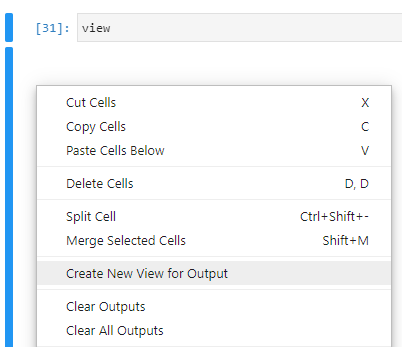

### Advanced usage

#### Custom coloring schemes and representations

In addition to different kinds of representations, you can also alter how each part of the displayed structure is colored. So far we have only used the default coloring, but NGL provides several default schemes (check [this list](https://nglviewer.org/ngl/api/manual/coloring.html) and also `nv.color.COLOR_SCHEMES`). The color schemes - and also names - can be used as arguments of a given representation.

In [38]:
print(nv.color.COLOR_SCHEMES)

[' ', 'picking', 'random', 'uniform', 'atomindex', 'residueindex', 'chainindex', 'modelindex', 'sstruc', 'element', 'resname', 'bfactor', 'hydrophobicity', 'value', 'volume', 'occupancy']


In [39]:
view = nv.show_pdbid("1PIE", default_representation=False)
view.add_ribbon("protein", color_scheme="sstruc")  # color based on secondary structure
view.add_ball_and_stick("ligand")
view.center()
view

NGLWidget()

You can show all side chains by applying the `licorice` scheme on the selection `sidechainAttached` directly (check the [selection query docs](https://nglviewer.org/ngl/api/manual/usage/selection-language.html) for more detail, e.g. `sidechainAttached` = "Select the side-chain and C-alpha atoms plus the backbone nitrogen in case of proline.").

Note that you can also ignore coloring _schemes_ and use a color directly. The `color` option supports any of these notations:

* Named colors like `red` or `blue`, but always _lowercase_! Check the full list of [named CSS colors](https://www.w3schools.com/cssref/css_colors.asp).
* Hexadecimal strings following the CSS notation. For example, yellow is encoded as `"#FFFF00"`.
* Hexadecimal integers. In this notation, yellow is encoded as `0xFFFF00`.

In [40]:
view.add_licorice(
    "sidechainAttached ", color="red"
)  # color="#FF0000" or color=0xFF0000 would also work!

What if you need a coloring scheme not available as a keyword? You can build it via two functions in `nglview.color.ColormakerRegistry`:

* `nv.color.ColormakerRegistry.add_selection_scheme` expects a `scheme_id` (a `str` with some name of your choice) plus a list of two-element sublists. Each sublist must define:
    * First element (`str`): the color _name_ or coloring _scheme_ to be applied
    * Second element (`str`): a selection query this color or scheme will be applied to
* `nv.color.ColormakerRegistry.add_scheme_func` expects a `scheme_id` (a `str` with some name of your choice) plus another `str` object that defines a JavaScript function that takes NGL atoms.

These examples are taken directly from the corresponding docstrings:

In [41]:
# residues from 1 to 100 will be blue; 101 to 1000 will be red
nv.color.ColormakerRegistry.add_selection_scheme(
    "my_custom_scheme", [["blue", "1-100"], ["red", "101-1000"]]
)

view = nv.show_pdbid("1EYE", default_representation=False)
view.add_cartoon(color="my_custom_scheme")
view.center()
view

NGLWidget()

> You can build the list of sublists programmatically for more complex visualizations. Check this [external notebook](https://github.com/volkamerlab/kissim_app/blob/f63327e/notebooks/fingerprints/feature_distribution_per_residue.ipynb#Side-chain-orientation) for an example!

In [42]:
js_function = """
this.atomColor = function (atom) {
    if (atom.serial < 500) {
        return 0x0000FF // blue
    } else if (atom.serial < 1000) {
        return 0xFF0000 // red
    } else {
        return 0x00FF00 // green
    }
}
"""
nv.color.ColormakerRegistry.add_scheme_func("awesome", js_function)
view = nv.show_pdbid("1EYE", default_representation=False)
view.center()
view.add_cartoon(color="awesome")
view

NGLWidget()

#### Add geometric objects at selected atoms

For some figures, it's often useful to mark certain areas of your structure with geometric or textual annotations. This functionality is available under a mixture of representation styles and `nglview.shape` functions.

In [43]:
view = nv.show_pdbid("1YES")
view

NGLWidget()

In [44]:
# Add volume for residues 0-50
view.add_surface("0-50")

Let's measure the distance between GLU223 and GLU200 `view.add_distance` takes a list of sublists. The sublists must contain atom indices (`int`) or a selection query that returns exactly one atom (in this case alpha carbon for residues 223 and 200). Don't forget the black label color or you won't see the distance value (default is white).

In [45]:
view.add_distance(atom_pair=[["223.CA", "200.CA"]], label_color="black")

Now we want to add a sphere next to ILE 151... The function is `view.shape.add_sphere(..)`:

In [46]:
view.shape.add_sphere?

Signature: view.shape.add_sphere(*args)
Docstring:
# add_sphere(position, color, radius, name)
>>> shape.add_sphere([0, 0, 9], [1, 0, 0], 1.5)
File:      ~/.local/miniconda/envs/teachopencadd_review/lib/python3.8/site-packages/nglview/shape.py
Type:      method


But it takes XYZ coordinates. How do we get access to that information? When you click on a residue or atom, you'll see that the top left corner of the widget exposes some details. We clicked on ILE151, and it printed `ATOM: [ILE]151:A.CA`. That means that the alpha carbon of residue 151 in chain A is selected. The best part is that this information is exposed to Python via `view.picked`! 

Go and select ILE151 before executing the next cell!

In [47]:
view.picked

{}

The coordinates are hence `view.picked["atom1"]["x"], view.picked["atom1"]["y"], view.picked["atom1"]["z"]`:

In [48]:
if "atom1" in view.picked:
    sphere = view.shape.add_sphere(
        [view.picked["atom1"]["x"], view.picked["atom1"]["y"], view.picked["atom1"]["z"]],
        [0.5, 0.5, 0.5],
        10,
        "gray sphere with 10A radius",
    )

To change the opacity of the sphere you will need to work with `.update_representation` and the component indices. It's a bit involved, but this is how you have to do it:

In [49]:
# The sphere is the last thing we added, so the component index is the last one (n_components - 1)
view.update_representation(component=view.n_components - 1, opacity=0.5)

#### Create interactive interfaces

One of the secret features of NGLView is the interactive GUI! Enabling it is surprisingly easy and will give you some extra control on the representations.

There are two GUIs included:

* The default (`gui=True`), which uses IPyWidgets
* The one NGL uses in their [demo app](http://nglviewer.org/ngl/)

In [50]:
# This is the default one
nv.show_pdbid("1RFO", gui=True)

NGLWidget()

Now bring in the NGL GUI. Sometimes the canvas itself does not load, so try to execute it twice. See discussion [here](https://github.com/nglviewer/nglview/issues/901#issuecomment-747163835) for more details.

In [51]:
view = nv.show_pdbid("1RFO")
view.gui_style = "NGL"
view

ThemeManager()

NGLWidget(gui_style='ngl')

##### Customize your own GUI with IPyWidgets

Since `nglview` exposes NGL as an IPython/Jupyter widget, it can be used to compose advanced dashboards in combination with the [IPyWidgets project](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html).

For example, a simple model picker for multimodel structures like in NMR studies.

In [52]:
view = nv.show_pdbid("1RFO", default_representation=False)
view.add_ribbon("protein")
view.center()
view

NGLWidget()

This is what we need to display a single model: 
* clear all representations 
* and add the ribbon only on model N with the syntax `/N`

In [53]:
view.clear()
view.add_ribbon("/0")

We can put this in a function.

In [54]:
def show_one_model_only(view, model_id):
    view.clear()
    view.add_ribbon(f"/{model_id}")

Look how it reacts to your function calls.

In [55]:
show_one_model_only(view, 1)

What if we let an IPyWidget do that for us? That's how `interact` works! Read the [documentation](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html#Using-Interact) for more details, but the gist is:

* `interact` takes a function that accepts some parameters.
* Those parameters can be sent via changes in a widget (`model_id`), or be manually defined as non-dynamic with `fixed(parameter)`.
* `interact` does some magic to infer which kind of widget is best for each parameter. If you pass a tuple of `int` (start, end), it will create a discrete slider, for example.
* Changing the state of the widget will result in calling that function with the new parameters. Since we are reacting on `view`, you will see the changes in real time!

In [56]:
from ipywidgets import interact, fixed

interact(show_one_model_only, view=fixed(view), model_id=(0, 9))
view

interactive(children=(IntSlider(value=4, description='model_id', max=9), Output()), _dom_classes=('widget-inte…

NGLWidget(n_components=1)

Change the value of the slider by dragging the widget!

Other interesting exercise is to change the type of representation with a widget. The full list is [here](https://nglviewer.org/ngl/api/manual/molecular-representations.html).

In [57]:
representations = ["backbone", "ball+stick", "line", "point", "ribbon"]


def change_representation(view, representation):
    view.clear()
    view.add_representation(representation)


view = view = nv.show_pdbid("1LEG")
interact(change_representation, view=fixed(view), representation=representations)
view

interactive(children=(Dropdown(description='representation', options=('backbone', 'ball+stick', 'line', 'point…

NGLWidget()

What about color schemes? Same principle! Note that in this case these are _arguments_ to a representation style. We are going to play with coloring schemes on _ribbon_.

In [58]:
def change_coloring(view, coloring):
    view.clear()
    view.add_representation("ribbon", color_scheme=coloring)


view = view = nv.show_pdbid("1HND")
interact(change_coloring, view=fixed(view), coloring=nv.color.COLOR_SCHEMES[1:])
view

interactive(children=(Dropdown(description='coloring', options=('picking', 'random', 'uniform', 'atomindex', '…

NGLWidget()

#### Access the JavaScript layer

NGL is an incredibly powerful JavaScript library. NGLView exports the most commonly used bits to Python, which allows us to control certain things in a very convenient way. However, sometimes we need to leverage both layers (JS and Python) to achieve some advanced representations. To do so, we can use some private methods in `nglview.NGLWidget`. Namely:

* `nglview.NGLWidget._remote_call`: Run a method on a NGL JS object, with positional arguments `args` and keyword arguments `kwargs`. You have to choose the target object first:
    * `target="Widget"`: The IPyWidget wrapper for the NGL Stage. [Check public methods](https://github.com/nglviewer/nglview/blob/2cd42979e0c39c163b6728f59ffea6e9d8cd56db/js/src/widget_ngl.ts#L73).
    * `target="Stage"`: Run any method on `Stage`. [List of methods](http://nglviewer.org/ngl/api/class/src/stage/stage.js~Stage.html#methodSummary).
    * `target="Viewer"`: Run any method on `Viewer`. [Check public methods](https://github.com/nglviewer/ngl/blob/master/src/viewer/viewer.ts#L173).
    * `target="compList"`: Run any method on `compList`, the list of loaded components in the stage. Maybe useful to query the JS list for a specific component.
    * `target="StructureComponent"`: Run any method on `StructureComponent`; each individual component. [List of methods](http://nglviewer.org/ngl/api/class/src/component/structure-component.js~StructureComponent.html).
* `nglview.NGLWidget._execute_js_code`: This will allow you to execute arbitrary JavaScript code. In that code, the JS counterpart of the IPyWidget can be referred by `this`. The NGL `Stage` instance is available at `this.stage`. It can be more powerful than `_remote_call` for complex cases!

Let's try some simple examples first.

In [59]:
view = nv.show_pdbid("2G1T")  # Human ABL1 kinase
view

NGLWidget()

Let's add some random text. This is possible via the `addShape` widget method. Some considerations:

* `Widget.addShape` requires arguments with a shape identifier or name (any `str`) and a list of sublists, where each sublist contains the kind of "shape" and its arguments. [See the function here](https://github.com/nglviewer/nglview/blob/2cd42979e0c39c163b6728f59ffea6e9d8cd56db/js/src/widget_ngl.ts#L759).
* The arguments for each type shape can be checked on NGL documentation; e.g. for [text](http://nglviewer.org/ngl/api/class/src/buffer/text-buffer.js~TextBuffer.html). Use the search bar to find the corresponding `*Buffer`.
* The arguments are passed _without_ keywords, just the values, positionally.

Let's add some red (encoded as RGB `[1, 0, 0]`) text (`TeachOpenCADD`) at the XYZ coordinates `[60, 0, -20]`.

In [60]:
view._remote_call(
    "addShape",
    target="Widget",
    args=("redText", [["text", [60, 0, -20], [1, 0, 0], 10, "TeachOpenCADD"]]),
)

Note that this can be achieved in a similar way using `_execute_js_code`. The difference is how to pass arguments, which would need to be substituted in an `f-string`. Hopefully, for some simple cases, JS and Python share a similar syntax (e.g. lists and strings). Let's add some more text, but now it will be blue and in a different position:

In [61]:
view._execute_js_code(
    """
this.addShape("blueText", [["text", [60, 20, -20], [0, 0, 1], 10, "TeachOpenCADD"]])
"""
)

This might be cumbersome in some cases, but in others we don't have a choice. For example, if we want to remove one of the shapes, we can only do it via `_execute_js_code`:

In [62]:
view._execute_js_code(
    """
this.stage.removeComponent(this.stage.getComponentsByName("blueText").first)
"""
)

##### Debugging JavaScript code

You might be wondering how you can find the right JS command if autocomplete does not work and the documentation is tricky to follow. Your best chance is using the Developer Tools in your browser!

The trick is to export the NGL Widget, represented by `this` under the `_execute_js_code` context, to your browser tab context. To do so, execute this snippet:

In [63]:
view._execute_js_code("document.nglview = this;")

If you open your Developer Tools console (<kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>J</kbd> in Chrome, <kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>K</kbd> in Firefox), you can type `document.nglview` there and inspect the object interactively:

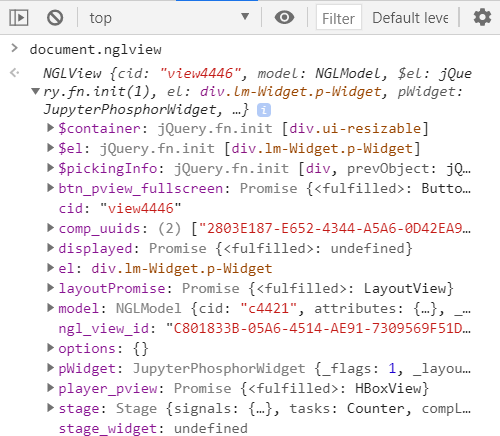

For your convenience, you can also execute one more line in your JavaScript console to alias it to something quicker to type:

```javascript
nv = document.nglview;
```

and inspect `nv` instead. Autocomplete with <kbd>Tab</kbd> should work as expected!

Tips and pitfalls:

* Most of the interesting stuff will be under `nv.stage`, like `nv.stage.compList`.
* The snippet you end up developing in the console will work as a `_execute_js_code` snippet as long as you replace back `document.nglview` (or your alias `nv`) with `this`.
* If you reload the NGL Widget from the notebook (e.g. by calling `nv.show_pdbid(...)` again), you need to re-run `view._execute_js_code("document.nglview = this;")`
* The console allows for `non-;` terminated lines, but make sure to end each line with `;` in the snippet.
* Javascript comments start with `//` not `#`

##### Practical example: show residues around ligand

This is a popular operation we often perform while studying protein-ligand complexes, but NGLView does not expose that directly. NGL does offer that functionality, so we can still query JS for this!

Let's open a kinase, e.g. EGFR, with an inhibitor bound. The PDB [structure](https://klifs.net/details.php?structure_id=783) `2ITO` seems to be bound by gefitinib with residue code `IRE`.

In [64]:
view = nv.show_pdbid("2ITO")
view.center("IRE")
view

NGLWidget()

In [65]:
view._execute_js_code(
    """
// Get first (and only) loaded component: our protein-ligand system
var system = this.stage.compList[0]; 
// Store current selection, we will need it laer
var prevSele = system.selection.string;
// Set selection to our desired ligand
system.setSelection("IRE");
// Select all atoms within 5A from the ligand
var around = system.structure.getAtomSetWithinSelection(system.selection, 5.0);
// Extend selection so it includes full residues
var around_complete = system.structure.getAtomSetWithinGroup(around);
// Add representation for those atoms
system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
// Restore selection to original one; otherwise changes won't be reflected
system.setSelection(prevSele)
"""
)

To parameterize this block of JS code you can use f-strings in a function! However, make sure to either:

* Escape already present curly braces `{ }` by doubling them:

```diff
- system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
+ system.addRepresentation("licorice", {{sele: around_complete.toSeleString()}});
```

* Split `{}`-containing substrings from the f-string parts, thanks to implicit string concatenation:

```python
js = (
f"""
// Get first (and only) loaded component: our protein-ligand system
var system = this.stage.compList[{index}]; 
// Store current selection, we will need it laer
var prevSele = system.selection.string;
// Set selection to our desired ligand
system.setSelection("{ligand}");
// Select all atoms within 5A from the ligand
var around = system.structure.getAtomSetWithinSelection(system.selection, {radius});
"""
# these extra quotes create two different strings: f-string above, regular string below
"""
// Extend selection so it includes full residues
var around_complete = system.structure.getAtomSetWithinGroup(around);
// Add representation for those atoms
system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
// Restore selection to original one; otherwise changes won't be reflected
system.setSelection(prevSele)
"""
# In the end they are joined anyway, but _after_ the formatting has taken place :)
)
```

Knowing this, you can define `show_residues_around` like this:

In [66]:
def show_residues_around(view, component_index=0, selection="ligand", radius=5.0):
    js = (
        f"""
        // Get first (and only) loaded component: our protein-ligand system
        var system = this.stage.compList[{component_index}]; 
        // Store current selection, we will need it laer
        var prevSele = system.selection.string;
        // Set selection to our desired ligand
        system.setSelection("{selection}");
        // Select all atoms within 5A from the ligand
        var around = system.structure.getAtomSetWithinSelection(system.selection, {radius});
        """
        """
        // Extend selection so it includes full residues
        var around_complete = system.structure.getAtomSetWithinGroup(around);
        // Add representation for those atoms
        system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
        // Restore selection to original one; otherwise changes won't be reflected
        system.setSelection(prevSele)
        """
    )
    view._execute_js_code(js)

Let's see if it works!

In [67]:
view = nv.show_pdbid("1KSW")
show_residues_around(view)
view.center("ligand")
view

NGLWidget()

This way of working with NGL opens a world of possibilities! The [issues labeled as Q&A](https://github.com/nglviewer/nglview/issues?q=is%3Aissue+label%3AQ%26A) in the `nglview` repository often resort this technique, and now you will be able to know what's going on!

### Troubleshooting tips

The Jupyter ecosystem is vast and changes rapidly. Keeping up-to-date with the latest additions is tricky and resource consuming, so ending up with a broken NGLView installation is not uncommon. The following packages might affect the functionality of NGLView. If one of them had a recent version change (specially major versions, like Jupyter Lab 2 -> Jupyter Lab 3), that might be one of the possible explanations for the errors you are seeing:

* `jupyter`
* `jupyterlab`
* `notebook`
* `ipywidgets`
* `nglview` itself

> Tip: If `nglview` can be imported but you don't see the canvas for `nv.demo()`, check the Developer Tools console (<kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>J</kbd> in Chrome, <kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>K</kbd> in Firefox) for error messages! 404 errors trying to load the JS NGL libraries are one of the most common ones. Check the steps below to troubleshoot!

#### Check which Jupyter platform you are working from

While the community transitions from Jupyter Notebook to Jupyter Lab, these alternative frontends for our beloved notebooks will coexist for a while, making everything a bit more confusing. Which one are you using? Check the table below.

| Application      | Package name         | Shell command      | URL style                 | Features                                                                                                                                                  |
|------------------|----------------------|--------------------|---------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Jupyter Notebook | `notebook`           | `jupyter notebook` | `127.0.0.1:8888/tree`     | One notebook per tab; Less resource intensive; Legacy project                                                                                             |
| Jupyter Lab v2   | `jupyterlab`         | `jupyter lab`      | `127.0.0.1:8888/lab`      | Multiple notebooks per tab; You can compose complex interfaces; Consumes more resources; Extensions must be built on the machine before installation      |
| Jupyter Lab v3   | `jupyterlab`         | `jupyter lab`      | `127.0.0.1:8888/lab`      | No need to build extensions                                                                                                                               |
| Jupyter Classic  | `jupyterlab-classic` | `jupyter classic`  | `127.0.0.1:8888/classic`  | Same UI style as `notebook`, but using the modern framework behind `lab`                                                                                  |


As a result, installing `nglview` on your machine involves different step depending on which Jupyter UI you are going to use.

#### How to install `nglview`, the right way

If you didn't know about the subtle differences  explained above, there's a chance you have several instances of `nglview` installed in your computer. Having both `conda` and `pip` available makes it more difficult, specially if you mix system installations with environment ones. Our advice is that you create a fresh environment for each project you work on, and specify their dependencies explicitly.

To get to that clean slate you might need to delete some files that will interfere with the environment-specific setting. 

##### Jupyter Notebook

```bash
conda install -c conda-forge nglview
nglview install
nglview enable
```

If this does not work, there's a chance Jupyter Notebook is finding other installations of `nglview` that interfere with the expected JavaScript libraries. The paths that Jupyter will check are listed with `jupyter --paths`.

To make sure the right ones are loaded (the ones in the active environment), you might need to delete some directories:

For Linux and Mac OS:

```bash
# User-level widgets
rm -rf ~/.local/share/jupyter/nbextensions/nglview-js-widgets/ 
# Global conda widgets
rm -rf $(conda info --base)/share/jupyter/nbextensions/nglview-js-widgets/
```

For Windows:

```
del %APPDATA%\jupyter\nbextensions\nglview-js-widgets
del %_CONDA_ROOT%\share\jupyter\nbextensions\nglview-js-widgets
```

Then, close Jupyter Notebook tabs and the command-line process, and relaunch. If this didn't work:

* Make sure the locations shown by `jupyter --paths` do not contain NGL files under `<prefix>/share/jupyter/nbextensions/nglview-js-widgets/`.
* Run `conda remove nglview` and / or `pip uninstall nglview` and start again.
* Hard-reload the browser tab with <kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>R</kbd>.
* Check this [excellent FAQ](https://github.com/SBRG/ssbio/wiki/Troubleshooting#issues-with-the-jupyter-notebook) for more ideas.

##### Jupyter Lab (v2 style)

Since Jupyter Lab uses a different extension system, it doesn't suffer from the path precedence issues shown above. However, you need to make sure the extension was installed _and_ built:

```bash
conda install -c conda-forge nglview
jupyter labextension install @jupyter-widgets/jupyterlab-manager nglview-js-widgets
```

##### Jupyter Lab (v3+ style)

Jupyter Lab v3 and above use a nice trick to precompile the JavaScript libraries, so you will _only_ need to install `nglview` with your favourite package manager.

```bash
conda install -c conda-forge nglview
```

## Discussion

NGLView is an incredibly powerful widget with a lot of features already accessible from the Python interface. But it's easy to miss the potential of the underlying JavaScript library! We hope you could see some of the possibilities available and that you've learned the tools you need to use to get there and beyond. If you are interested in some more examples of advanced uses, check the links below.

<!-- * [Link to Plipify's PLIP depiction when it's public](#) -->
* [Adding an automatic NGLView preview for your molecular objects](https://github.com/openforcefield/openff-toolkit/pull/560)
* [Customizing the overlay tooltips](https://github.com/mosdef-hub/mbuild/pull/600)

## Quiz

NGLView is now part of your CADD toolbox. Here you have some interesting exercises:

1. Load one of the structures for ABL1 (available at [KLIFS.net](https://klifs.net/result.php?kinase=ABL1)), without downloading anything manually. Check talktorial `T013` for more details about KLIFS!
2. Color the pocket residues in a different tone for easy visual identification.
3. Show the side chains of those residues that are potentially interacting with the ligand, if present.
4. Create a small interface that lists all ABL1 structures available at KLIFS. Clicking on their PDB ID should load the structure and the visualizations discussed above.